In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp
import sklearn.model_selection as ms
import sklearn.metrics as m
import sklearn.linear_model as lm 
import sklearn.tree as t
import sklearn.ensemble as ens 
import sklearn.neighbors as n
import sklearn.naive_bayes as nb 

import optuna

plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

RS = 8

c:\Users\honor\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels,      default = 0
                n_gyr_channels  (int): Number of Gyroscope channels,          default = 0
                n_mag_channels  (int): Number of Magnetometer channels,       default = 0
                n_enc_channels  (int): Number of Encoder channels,            default = 0
                button_ch      (bool): If button channel is present,          default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present,       default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Data

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

gestures

,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19563,3,6,7,4,2,0,6,3,13,8,...,1,0,0,0,0,0,0,0,0,1201356
19564,26,6,5,3,2,1,4,4,9,7,...,-2,0,0,0,0,0,0,0,0,1201389
19565,14,7,6,4,2,0,6,5,13,8,...,0,0,0,0,0,0,0,0,0,1201422
19566,30,6,6,4,2,0,5,5,10,6,...,-1,0,0,0,0,0,0,0,0,1201455


### Abbreviations
* OMG — optomiography  
* ACC — accelerometer  
* GYR — gyroscope  
* ENC — encoders (fingers of prosthesis or gloves)  
* model — model of data  

### X features 
* '0', ..., '49' - каналы OMG датчиков
* 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
* 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
* 'BUTTON' - не используется
* 'SYNC' - синхронизация данных с протоколом
* 'ts' - метка времени

In [4]:
gestures.columns 

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [5]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


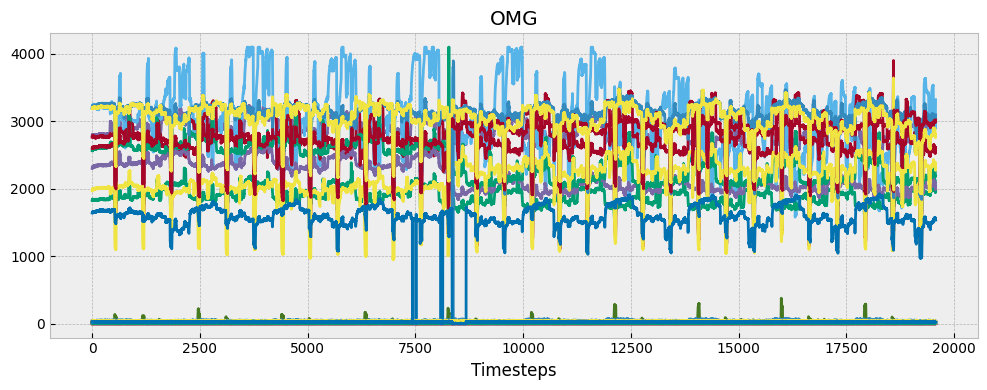

In [6]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

# Protocol

In [7]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10) 

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [8]:
gestures['SYNC'].value_counts()

SYNC
0      11266
57        58
67        58
97        47
135       47
       ...  
52        46
1         45
103       45
104       45
12        39
Name: count, Length: 181, dtype: int64

In [9]:
le = pp.LabelEncoder()

# FIT & TRANSFORM
gestures_protocol['gesture'] = le.fit_transform(
    gestures_protocol[[
        "Thumb", "Index", "Middle", "Ring", "Pinky",
        'Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

gestures_protocol['gesture']

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [10]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [11]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

y_cmd, y_cmd.__len__()

(array([0, 0, 0, ..., 0, 0, 0]), 19568)

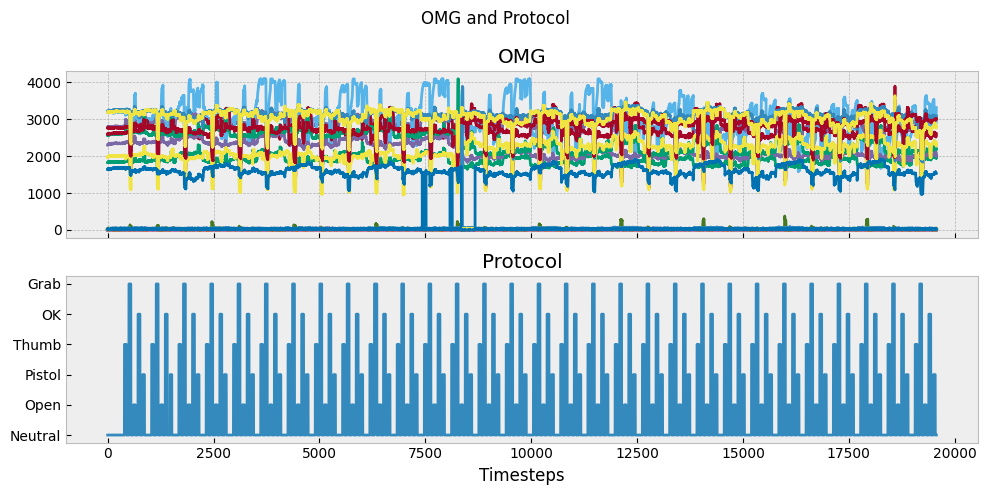

In [12]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [13]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [14]:
last_train_idx = (df_meta[df_meta['montage'] == palm_file.split('/')[-1]]
                  ['last_train_idx'].values[0]) 

last_train_idx 

15679

In [15]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


In [16]:
X_train

array([[12,  8,  5, ..., 12, 44, 28],
       [13,  8,  4, ..., 14, 32, 27],
       [12,  5,  9, ..., 14, 41, 27],
       ...,
       [27,  8,  5, ..., 13, 36, 28],
       [ 8,  6,  5, ..., 11, 34, 24],
       [ 0,  6,  5, ..., 14, 39, 29]], dtype=int64)

In [17]:
y_train 

array([0, 0, 0, ..., 2, 2, 2])

# Modeling, Prediction & Metrics

In [18]:
def model_report(model):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if ((len(np.unique(y_pred_train)) != len(GESTURES)) or 
        (len(np.unique(y_pred_test)) != len(GESTURES))):
        raise ValueError('Bad prediction') 

    print('Train: ', m.f1_score(y_train, 
                                y_pred_train, 
                                #labels=GESTURES, 
                                average='weighted'), '\n')
    print('Test: ', m.f1_score(y_test, 
                               y_pred_test, 
                               #labels=GESTURES, 
                               average='weighted'))
    
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    y_train_df = pd.DataFrame({'y_train': y_train,
                            'y_pred_train': y_pred_train})
    y_test_df = pd.DataFrame({'y_test': y_test, 
                            'y_pred_test': y_pred_test})

    sns.lineplot(y_train_df, ax=ax[0])
    sns.lineplot(y_test_df, ax=ax[1])

    ax[0].set_yticks(range(len(GESTURES)), GESTURES)
    ax[0].set_title('Train')

    ax[1].set_xlabel('Timesteps')
    ax[1].set_yticks(range(len(GESTURES)), GESTURES)
    ax[1].set_title('Test')

    fig.show()

## Logistic Regression (baseline)

Train:  0.6270366145646896 

Test:  0.6292414905847311


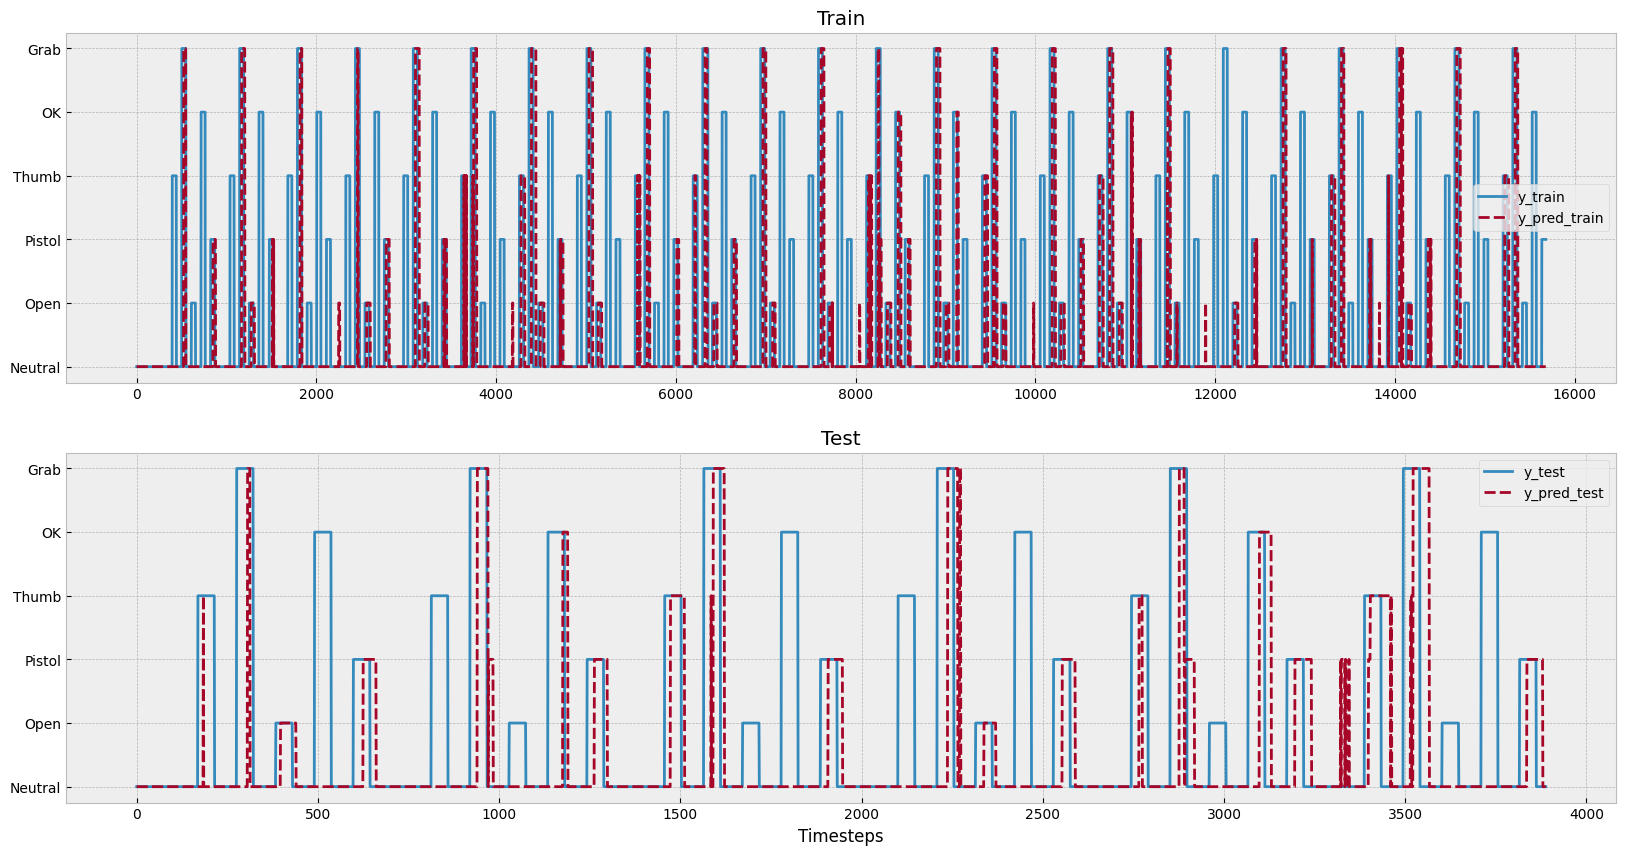

In [19]:
model = lm.LogisticRegression()

model_report(model)

In [20]:
def opt_logreg(trial: optuna.trial.Trial):
    model = lm.LogisticRegression(
        penalty = trial.suggest_categorical('penalty', ['l2', None]), 
        C = trial.suggest_float('C', 0.0001, 1, step=0.01), 
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial']), 
        max_iter = trial.suggest_int('max_iter', 100, 10000, step=100),
        solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
        random_state=RS
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = m.f1_score(y_test, y_pred, average='weighted')
    
    return score


study_logreg = optuna.create_study(study_name='Logistic Regression', direction='maximize')

study_logreg.optimize(opt_logreg, n_trials=30)

[I 2024-01-23 21:23:34,019] A new study created in memory with name: Logistic Regression
[I 2024-01-23 21:24:42,346] Trial 0 finished with value: 0.6827342738830644 and parameters: {'penalty': None, 'C': 0.0101, 'multi_class': 'multinomial', 'max_iter': 7800, 'solver': 'saga'}. Best is trial 0 with value: 0.6827342738830644.
[I 2024-01-23 21:25:08,299] Trial 1 finished with value: 0.6858322409467613 and parameters: {'penalty': None, 'C': 0.4701, 'multi_class': 'multinomial', 'max_iter': 9400, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6858322409467613.
[I 2024-01-23 21:25:12,840] Trial 2 finished with value: 0.677734395059215 and parameters: {'penalty': None, 'C': 0.7701, 'multi_class': 'multinomial', 'max_iter': 1500, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6858322409467613.
[I 2024-01-23 21:26:25,881] Trial 3 finished with value: 0.6827342738830644 and parameters: {'penalty': 'l2', 'C': 0.6301, 'multi_class': 'multinomial', 'max_iter': 4100, 'solver': 'saga'}. Best i

# Real-time inference

In [ ]:
import time
import serial 
from IPython.display import clear_output

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


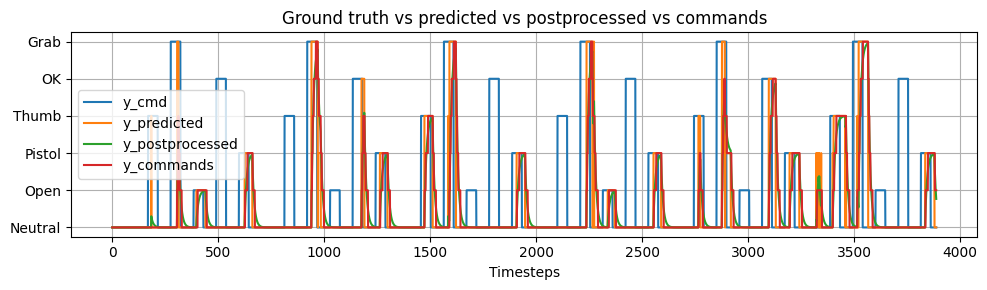

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(m.classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

AttributeError: module 'serial' has no attribute 'Serial'